# Count tangles on a slide

In [11]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide
import scipy.ndimage

# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

# Import wildcat mods
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:     5026 MB
Device:  cuda:0


In [2]:
# Global properties
num_classes=2
input_size=224
input_size_wildcat=224
batch_size=16
batch_size_wildcat=16
resnet_flavor=18
fold = "fold_INDD119294"
data_dir = "/home/pyushkevich/data/thon2019/exp01/%s" % (fold,)
model_dir="/home/pyushkevich/resnet/thon2019/exp01/%s" % (fold,)

In [3]:
# Read the wildcat model
model_wildcat = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
model_wildcat.load_state_dict(torch.load(os.path.join(model_dir, "model_%s_wcu_50_15epoch.dat" % (fold,))))

# Set evaluation mode
model_wildcat.eval()

# Send model to GPU
model_wildcat = model_wildcat.to(device)

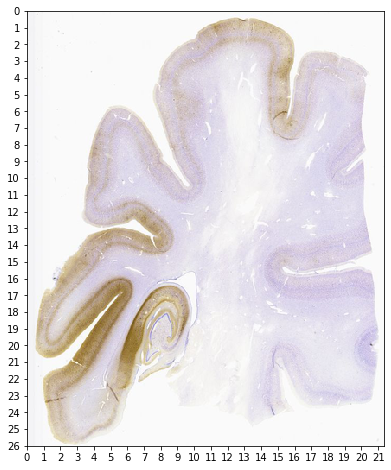

In [4]:
# Read a slide and show thumbnail
# osl=openslide.OpenSlide('/home/pyushkevich/data/raw/HNL-33-18_HR3p_TAU_36.tif')
osl=openslide.OpenSlide('/home/pyushkevich/data/raw/HNL-32-18_HR3a_TAU_36.tif')
plt.figure(figsize=(16,8))
plt.imshow(osl.get_thumbnail((512,512)), extent=(0,osl.level_dimensions[0][0]/4096,osl.level_dimensions[0][1]/4096,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/4096));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/4096));

In [5]:
# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 512

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 4096

# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
padding_size_rel = 1.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=2

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=4

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size_wildcat

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((2, out_dim[0], out_dim[1]))

# Range of pixels to scan
#u_range,v_range = (5,19),(19,31)
u_range,v_range = (0,n_win[0]),(0,n_win[1])

# Range non-overlapping windows
t_00 = timeit.default_timer()
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp,wp = x-padding_size_raw,y-padding_size_raw,window_size_raw+2*padding_size_raw
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")
        t1 = timeit.default_timer()
                
        # Compute the desired size of input to wildcat
        wwc = int(wp * input_size_wildcat / patch_size_raw)

        # Resample the chunk for the two networks
        tran = transforms.Compose([
            transforms.Resize((wwc,wwc)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Convert the read chunk to tensor format
        with torch.no_grad():
            
            # Apply transforms and turn into correct-size torch tensor
            chunk_tensor=torch.unsqueeze(tran(chunk_img),dim=0).to(device)
            
            # Forward pass through the wildcat model
            x_clas = model_wildcat.forward_to_classifier(chunk_tensor)
            x_cpool = model_wildcat.spatial_pooling.class_wise(x_clas)

            # Scale the cpool image to desired size
            x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

            # Extract the central portion of the output
            p0,p1 = padding_size_out,(padding_size_out+window_size_out)
            x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]
            
            # Stick it into the output array
            xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
            yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
            density[0,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,0,:,:].transpose()
            density[1,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,1,:,:].transpose()
                
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Chunk: (     0,     0) Times: IO=1.2760 WldC=0.9917 Totl=  2.2677
Chunk: (     0,     1) Times: IO=1.4250 WldC=0.9067 Totl=  2.3317
Chunk: (     0,     2) Times: IO=1.3998 WldC=0.8741 Totl=  2.2739
Chunk: (     0,     3) Times: IO=1.3842 WldC=0.8830 Totl=  2.2671
Chunk: (     0,     4) Times: IO=1.3460 WldC=0.9135 Totl=  2.2595
Chunk: (     0,     5) Times: IO=1.3914 WldC=0.8784 Totl=  2.2698
Chunk: (     0,     6) Times: IO=1.3239 WldC=0.9105 Totl=  2.2344
Chunk: (     0,     7) Times: IO=1.3566 WldC=0.8778 Totl=  2.2344
Chunk: (     0,     8) Times: IO=1.3149 WldC=0.8780 Totl=  2.1929
Chunk: (     0,     9) Times: IO=1.3784 WldC=0.8766 Totl=  2.2550
Chunk: (     0,    10) Times: IO=1.3216 WldC=0.8789 Totl=  2.2005
Chunk: (     0,    11) Times: IO=1.3586 WldC=0.8742 Totl=  2.2328
Chunk: (     0,    12) Times: IO=1.3462 WldC=0.8784 Totl=  2.2246
Chunk: (     0,    13) Times: IO=1.2944 WldC=0.9407 Totl=  2.2351
Chunk: (     0,    14) Times: IO=1.3866 WldC=0.9093 Totl=  2.2959
Chunk: (  

In [62]:
# Compute the default v_range
v_range_def = (0,20)

# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,vrange=v_range_def,transpose=False,gaussian=None):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)

    # Gaussian smooth if requested
    if gaussian is not None:
        t_map = scipy.ndimage.gaussian_filter(t_map, gaussian)
    
    t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    t_map=np.where(t_map > 0, t_map, 0)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("viridis"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    # ax[1].colorbar(cs)
    fig.show()

<Figure size 1152x1152 with 0 Axes>

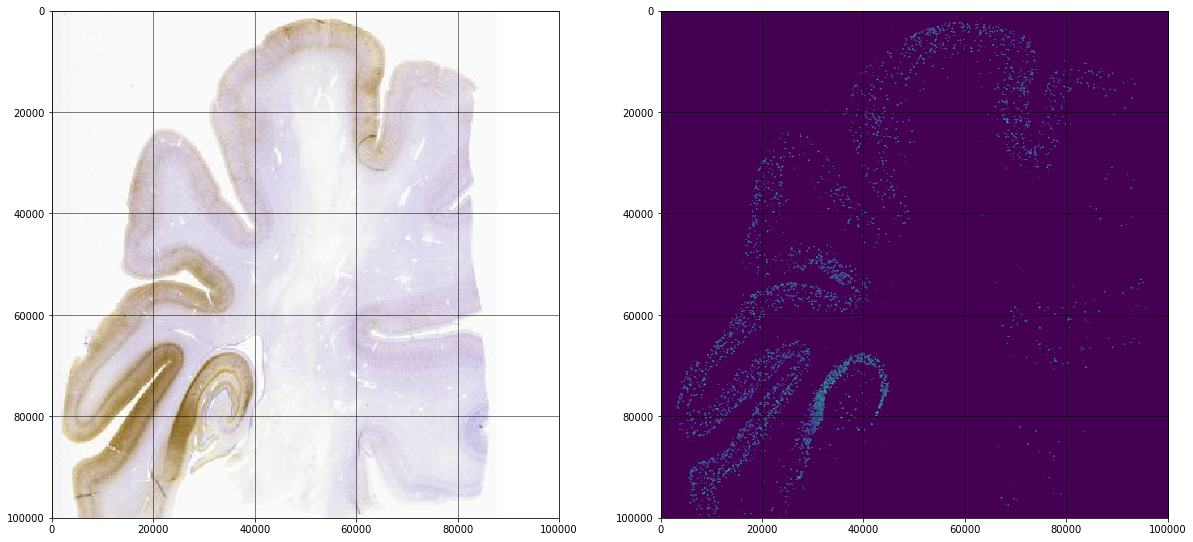

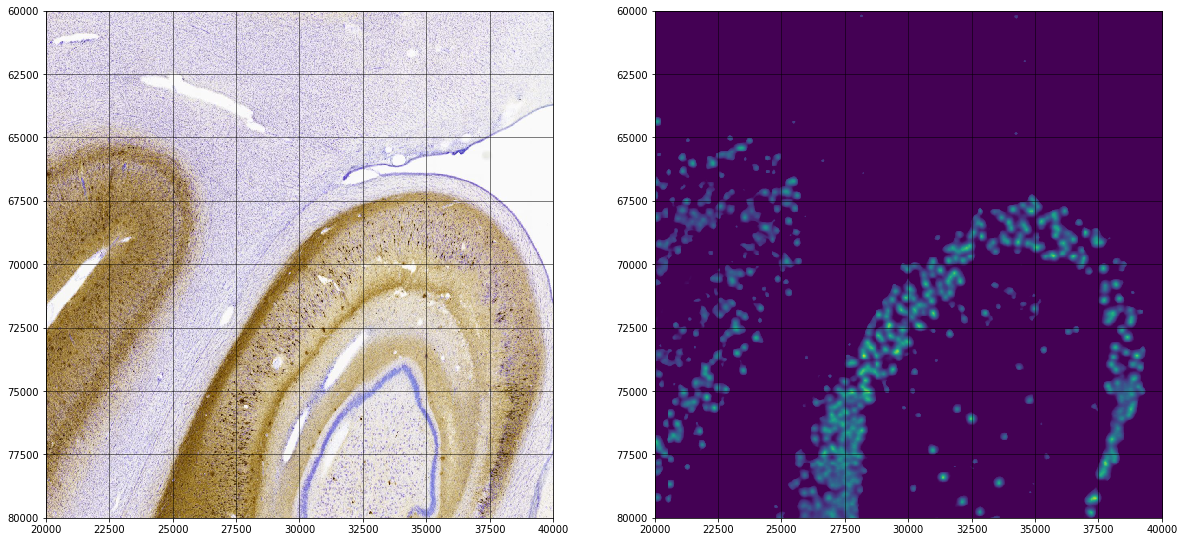

In [63]:
plt.figure(figsize=(16,16))
plot_classification_region(0,0,100000,100000,8)
plt.savefig('sshot/wsi_zoom_1.png', dpi=300)
plot_classification_region(20000,60000,40000,80000,4)
plt.savefig('sshot/wsi_zoom_2.png', dpi=300)

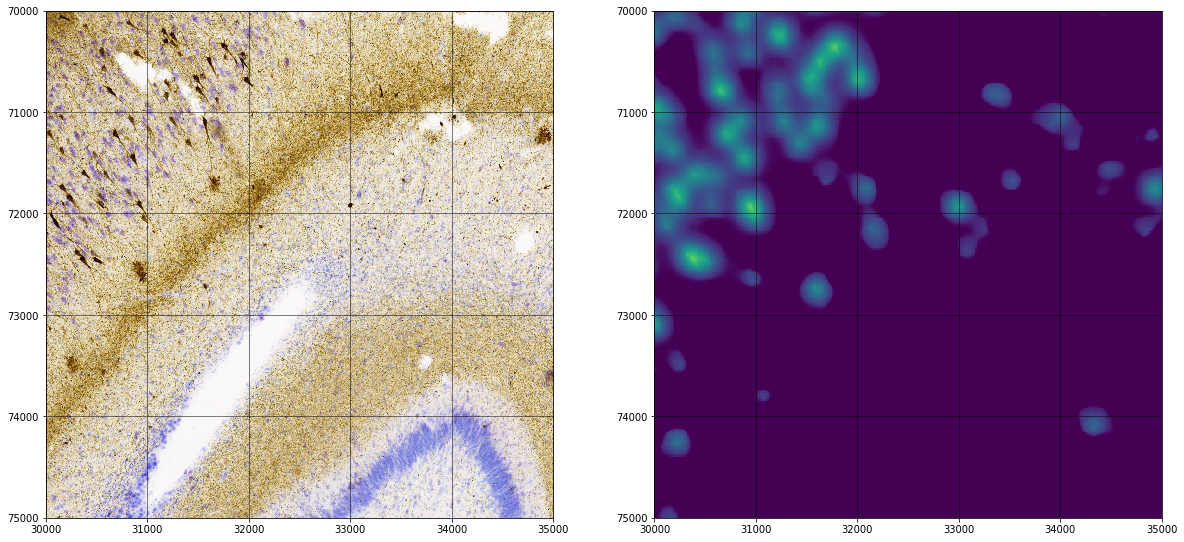

In [64]:
plot_classification_region(30000,70000,35000,75000,1)
plt.savefig('sshot/wsi_zoom_.png', dpi=300)

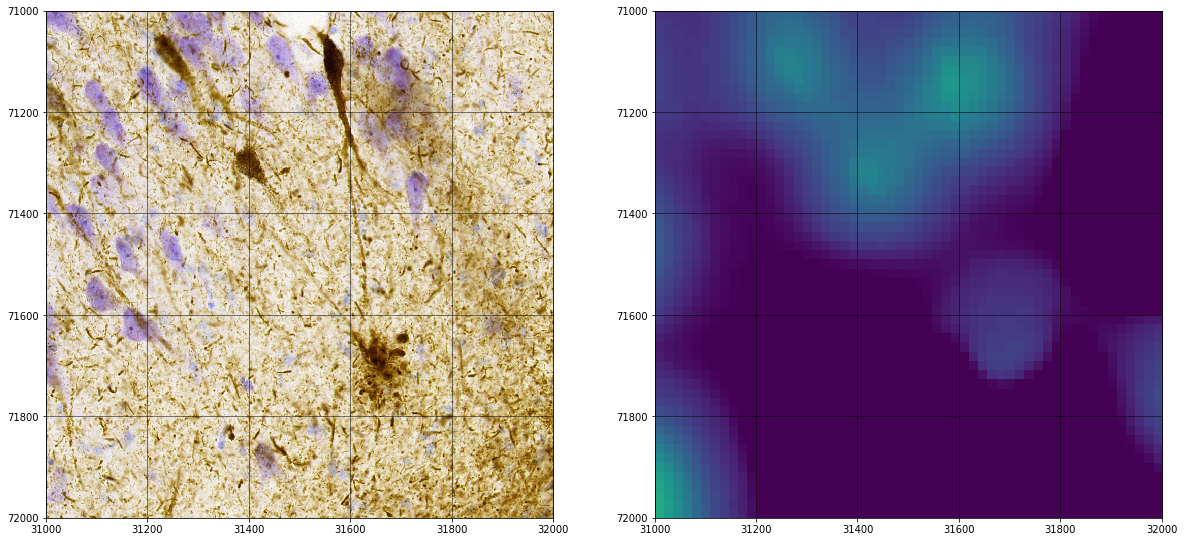

In [57]:
plot_classification_region(31000,71000,32000,72000,0)
plt.savefig('sshot/wsi_zoom_4.png', dpi=300)